In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("=" * 80)
print("GREEN BIKES TOURS - ANALYSE DES DONNÉES DU TOUR NOCTURNE")
print("=" * 80)
print(f"Période d'analyse: 23 mai 2022 - 19 juin 2022")
print(f"Focus: Tour nocturne à vélo (18h15 - 23h00)")
print("=" * 80)

# =============================================================================
# 1. CHARGEMENT ET AUDIT INITIAL DES DONNÉES
# =============================================================================
print("\n📁 ÉTAPE 1: CHARGEMENT DES DONNÉES")
print("-" * 50)

# Dictionnaire pour stocker tous les dataframes
data_files = {}
load_errors = []

# Fonction pour charger les fichiers avec gestion d'erreurs
def load_file_safe(file_path, file_name, sep=';', encoding='utf-8'):
    """Charge un fichier de manière sécurisée avec plusieurs tentatives"""
    try:
        # Tentative 1: CSV avec séparateur spécifié
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path, sep=sep, encoding=encoding)
        # Tentative 2: Excel
        elif file_path.endswith(('.xlsx', '.xls')):
            df = pd.read_excel(file_path)
        else:
            # Tentative par défaut
            df = pd.read_csv(file_path, sep=sep, encoding=encoding)
        
        print(f"✅ {file_name}: {df.shape[0]} lignes, {df.shape[1]} colonnes")
        return df
    except Exception as e:
        print(f"❌ Erreur {file_name}: {e}")
        load_errors.append(f"{file_name}: {e}")
        return None

# Chargement des fichiers principaux
print("\n🔄 Chargement des fichiers principaux...")

# 1. Employés
employees_df = load_file_safe('data/Employees/employees_table.csv', 'Employés')
if employees_df is not None:
    data_files['employees'] = employees_df

# 2. Réservations
bookings_df = load_file_safe('data/Bookings/Bookings.xlsx', 'Réservations')
if bookings_df is not None:
    data_files['bookings'] = bookings_df

# 3. Clients
customers_df = load_file_safe('data/Customers/customers_extract.xlsx', 'Clients')
if customers_df is not None:
    data_files['customers'] = customers_df
print(customers_df.columns)

# 4. Logs des employés
employee_logs_df = load_file_safe('data/Employee Logs/Employee_Night_Logs.xlsx', 'Logs employés')
if employee_logs_df is not None:
    data_files['employee_logs'] = employee_logs_df

# 5. Planning du bureau
office_schedule_df = load_file_safe('data/Office Schedule/Employee_Evening_Schedule.xlsx', 'Planning bureau')
if office_schedule_df is not None:
    data_files['office_schedule'] = office_schedule_df

# 6. Avis
reviews_df = load_file_safe('data/Reviews/tour_reviews.csv', 'Avis clients')
if reviews_df is not None:
    data_files['reviews'] = reviews_df

# 7. Météo
weather_df = load_file_safe('data/Weather/weather.csv', 'Météo')
if weather_df is not None:
    data_files['weather'] = weather_df
print(weather_df.columns)

# 8. Chargement des logs (tous les sous-dossiers)
print("\n🔄 Chargement des fichiers de logs...")
logs_folders = [
    'Count_Send_Logs',
    'Launch_Logs', 
    'Launchpad_1_Logs',
    'Launchpad_2_Logs',
    'Meeting_Point_Logs',
    'Office_Logs',
    'Return_Logs'
]

logs_data = {}
for folder in logs_folders:
    folder_path = f'data/Logs/{folder}'
    if os.path.exists(folder_path):
        logs_data[folder] = []
        for file in os.listdir(folder_path):
            if file.endswith(('.csv', '.xlsx')):
                file_path = os.path.join(folder_path, file)
                df = load_file_safe(file_path, f'{folder}/{file}')
                if df is not None:
                    df['source_file'] = file
                    df['log_type'] = folder
                    logs_data[folder].append(df)

for i, df in enumerate(logs_data['Meeting_Point_Logs']):
    # Si la colonne unique existe, on la splitte
    if list(df.columns)[0] == 'tag_id,party_id,log_time':
        # Split la colonne unique en 3 colonnes
        new_cols = df['tag_id,party_id,log_time'].str.split(',', expand=True)
        new_cols.columns = ['tag_id', 'party_id', 'log_time']
        # Remplace les colonnes dans le DataFrame
        df = pd.concat([new_cols, df.drop(columns=['tag_id,party_id,log_time'])], axis=1)
        logs_data['Meeting_Point_Logs'][i] = df

for i, df in enumerate(logs_data['Office_Logs']):
    # Si la colonne unique existe, on la splitte
    if list(df.columns)[0] == 'tag_id,party_id,log_time':
        # Split la colonne unique en 3 colonnes
        new_cols = df['tag_id,party_id,log_time'].str.split(',', expand=True)
        new_cols.columns = ['tag_id', 'party_id', 'log_time']
        # Remplace les colonnes dans le DataFrame
        df = pd.concat([new_cols, df.drop(columns=['tag_id,party_id,log_time'])], axis=1)
        logs_data['Office_Logs'][i] = df

# 9. Chargement des ventes du bureau (Office Sales)
print("\n🔄 Chargement des fichiers de ventes...")
office_sales_data = []
sales_folder = 'data/Office Sales'
if os.path.exists(sales_folder):
    for file in os.listdir(sales_folder):
        if file.endswith(('.csv', '.xlsx')):
            file_path = os.path.join(sales_folder, file)
            df = load_file_safe(file_path, f'Office Sales/{file}')
            if df is not None:
                df['source_file'] = file
                office_sales_data.append(df)

GREEN BIKES TOURS - ANALYSE DES DONNÉES DU TOUR NOCTURNE
Période d'analyse: 23 mai 2022 - 19 juin 2022
Focus: Tour nocturne à vélo (18h15 - 23h00)

📁 ÉTAPE 1: CHARGEMENT DES DONNÉES
--------------------------------------------------

🔄 Chargement des fichiers principaux...
✅ Employés: 23 lignes, 11 colonnes
✅ Réservations: 16 lignes, 7 colonnes
✅ Clients: 1304 lignes, 7 colonnes
Index(['Customerid', 'first_name', 'last_name', 'email', 'gender',
       'nationality', 'Phone'],
      dtype='object')
✅ Logs employés: 7 lignes, 3 colonnes
✅ Planning bureau: 7 lignes, 4 colonnes
✅ Avis clients: 156 lignes, 3 colonnes
✅ Météo: 84 lignes, 5 colonnes
Index(['Day', 'time_of_day', 'weather', 'severity', 'degrees'], dtype='object')

🔄 Chargement des fichiers de logs...
✅ Count_Send_Logs/01-06-2022_night_count_send.csv: 120 lignes, 1 colonnes
✅ Count_Send_Logs/02-06-2022_night_count_send.csv: 130 lignes, 1 colonnes
✅ Count_Send_Logs/03-06-2022_night_count_send.csv: 132 lignes, 1 colonnes
✅ Count_S

In [79]:
# =============================================================================
# ÉTAPE 1: AUDIT ET NETTOYAGE DES DONNÉES
# =============================================================================
import re
print("\n🔍 ÉTAPE 1: AUDIT ET NETTOYAGE DES DONNÉES")
print("-" * 50)

# 1.1 CONSOLIDATION DES LOGS
print("\n📊 Consolidation des logs par type...")

# Consolidation Meeting Point Logs
meeting_point_all = []
for df in logs_data['Meeting_Point_Logs']:
    match = re.search(r'(\d{2}-\d{2}-\d{4})', df['source_file'].iloc[0])
    if match:
        date_str = match.group(1)
        df['date'] = pd.to_datetime(date_str, format='%d-%m-%Y')
    else:
        df['date'] = pd.NaT
    # Correction ici : utiliser la colonne 'log_time'
    if 'log_time' in df.columns:
        df['timestamp'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d') + ' ' + df['log_time'], errors='coerce')
    else:
        df['timestamp'] = pd.NaT
    df = df.dropna(subset=['timestamp'])
    meeting_point_all.append(df)

meeting_point_df = pd.concat(meeting_point_all, ignore_index=True)
print(f"✅ Meeting Point: {len(meeting_point_df)} enregistrements")

# Consolidation Office Logs
print("=== DEBUG Office_Logs ===")
for i, df in enumerate(logs_data['Office_Logs']):
    print(f"Office log {i}: shape={df.shape}, columns={df.columns}")
    print(df.head(2))
    print("source_file:", df['source_file'].iloc[0] if not df.empty else "EMPTY")
office_all = []
for df in logs_data['Office_Logs']:
    print(df.shape, df.columns, df.head(1))
    # Ignore les DataFrames vides
    if df.empty:
        continue
    # Récupère le nom du fichier (même valeur pour toutes les lignes)
    file_name = df['source_file'].iloc[0] if 'source_file' in df.columns else None
    if not file_name:
        print("⚠️ Pas de source_file pour ce log Office, skip")
        continue
    date_str = file_name.split('_')[0]
    try:
        df['date'] = pd.to_datetime(date_str, format='%d-%m-%Y')
    except Exception as e:
        print(f"Erreur parsing date pour {file_name}: {e}")
        df['date'] = pd.NaT
    if 'log_time' in df.columns:
        df['timestamp'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d') + ' ' + df['log_time'], errors='coerce')
    else:
        print("⚠️ log_time manquant dans Office_Logs")
        df['timestamp'] = pd.NaT
    df = df.dropna(subset=['timestamp'])
    office_all.append(df)


office_df = pd.concat(office_all, ignore_index=True)

print(f"✅ Office: {len(office_df)} enregistrements")
print(office_df[['date', 'timestamp']].head())
print(office_df['date'].unique())


# Consolidation Launch Logs
launch_all = []
for df in logs_data['Launch_Logs']:
    print(df.columns)
    date_str = df['source_file'].iloc[0].split('_')[0]
    df['date'] = pd.to_datetime(date_str, format='%d-%m-%Y')
    df['timestamp'] = pd.to_datetime(df.iloc[:, 0], errors='coerce')
    df = df.dropna(subset=['timestamp'])
    launch_all.append(df)

launch_df = pd.concat(launch_all, ignore_index=True)
print(f"✅ Launch: {len(launch_df)} enregistrements")

# Consolidation Return Logs
return_all = []
for df in logs_data['Return_Logs']:
    print(df.columns)
    date_str = df['source_file'].iloc[0].split('_')[0]
    df['date'] = pd.to_datetime(date_str, format='%d-%m-%Y')
    df['timestamp'] = pd.to_datetime(df.iloc[:, 0], errors='coerce')
    df = df.dropna(subset=['timestamp'])
    return_all.append(df)

return_df = pd.concat(return_all, ignore_index=True)
print(f"✅ Return: {len(return_df)} enregistrements")

# Regroupe tous les logs consolidés dans un dictionnaire
consolidated_logs = {
    'meeting_point': meeting_point_df,
    'office': office_df,
    'launch': launch_df,
    'return': return_df
}

# Récupère toutes les dates valides
all_dates_list = []
for df in consolidated_logs.values():
    if 'date' in df.columns and not df.empty:
        all_dates_list.extend(df['date'].dropna().tolist())

if all_dates_list:
    min_date = min(all_dates_list)
    max_date = max(all_dates_list)
    all_dates = pd.date_range(start=min_date, end=max_date)
    master_table = pd.DataFrame({'date': all_dates})
else:
    print("⚠️ Aucun log avec une date valide trouvé, master_table vide.")
    master_table = pd.DataFrame({'date': []})

# Agrège les métriques quotidiennes pour chaque type de log
for log_type, df in consolidated_logs.items():
    print(f"{log_type} columns: {df.columns}")  # Pour debug
    if 'date' in df.columns:
        if not np.issubdtype(df['date'].dtype, np.datetime64):
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
        if 'timestamp' in df.columns:
            daily_metrics = df.groupby('date').agg({
                'timestamp': ['count', 'min', 'max']
            }).round(2)
            daily_metrics.columns = [f'{log_type}_{col[1]}' for col in daily_metrics.columns]
            daily_metrics = daily_metrics.reset_index()
            # FORCE le type datetime ici AVANT le merge
            daily_metrics['date'] = pd.to_datetime(daily_metrics['date'], errors='coerce')
            master_table['date'] = pd.to_datetime(master_table['date'], errors='coerce')
            master_table = master_table.merge(daily_metrics, on='date', how='left')
        else:
            print(f"⚠️ Colonne 'timestamp' absente dans {log_type}")
    else:
        print(f"⚠️ Colonne 'date' absente dans {log_type}")

print(master_table.head())

# 1.2 NETTOYAGE DES DONNÉES CLIENTS
print("\n🧹 Nettoyage des données clients...")
customers_clean = customers_df.copy()

# Suppression des doublons
customers_clean = customers_clean.drop_duplicates(subset=['Customerid'], keep='first')
print(f"✅ Clients après suppression doublons: {len(customers_clean)}")

# Validation des IDs clients
print("=== IDs CLIENTS ===")

customer_ids = set(data_files['customers']['Customerid'].dropna())
print(f"IDs clients uniques: {len(customer_ids)}")

# Vérifier cohérence avec bookings
if 'bookings' in data_files and 'Customerid' in data_files['bookings'].columns:
    booking_customer_ids = set(data_files['bookings']['Customerid'].dropna())
    missing_customers = booking_customer_ids - customer_ids
    print(f"Clients manquants dans réservations: {len(missing_customers)}")

# Traitement des valeurs manquantes
customers_clean['nationality'] = customers_clean['nationality'].fillna('Unknown')
print(f"✅ Valeurs manquantes traitées")

# 1.3 NETTOYAGE DES DONNÉES MÉTÉO


print("\n🌤️ Nettoyage des données météo...")
weather_clean = weather_df.copy()
weather_clean['date'] = pd.to_datetime(weather_clean['Day'])  # Correction ici
weather_clean = weather_clean.dropna(subset=['degrees', 'weather'])  # Adapte les noms de colonnes
print(f"✅ Météo nettoyée: {len(weather_clean)} jours")


# 1.4 NETTOYAGE DES AVIS
print("\n💬 Nettoyage des avis clients...")
reviews_clean = reviews_df.copy()
reviews_clean['date'] = pd.to_datetime(reviews_clean['date'])
reviews_clean = reviews_clean.dropna(subset=['rating'])
reviews_clean['rating'] = pd.to_numeric(reviews_clean['rating'], errors='coerce')
reviews_clean = reviews_clean[(reviews_clean['rating'] >= 1) & (reviews_clean['rating'] <= 5)]
print(f"✅ Avis nettoyés: {len(reviews_clean)} avis")

# 1.5 CONSOLIDATION OFFICE SALES
print("\n💰 Consolidation des ventes bureau...")
if office_sales_data:
    office_sales_df = pd.concat(office_sales_data, ignore_index=True)
    office_sales_df['date'] = pd.to_datetime(office_sales_df['date'], errors='coerce')
    office_sales_df = office_sales_df.dropna(subset=['date'])
    print(f"✅ Ventes bureau: {len(office_sales_df)} transactions")
else:
    print("⚠️ Pas de données de ventes bureau")

print("\n✅ NETTOYAGE TERMINÉ - Données prêtes pour l'analyse")

print("Colonnes Office_df :", office_df.columns)
print("Extrait Office_df :")
print(office_df.head(10))
print("Dates uniques Office_df :", office_df['date'].unique())
print("Extrait source_file :", office_df['source_file'].unique())


🔍 ÉTAPE 1: AUDIT ET NETTOYAGE DES DONNÉES
--------------------------------------------------

📊 Consolidation des logs par type...
✅ Meeting Point: 2554 enregistrements
=== DEBUG Office_Logs ===
Office log 0: shape=(120, 5), columns=Index(['tag_id', 'party_id', 'log_time', 'source_file', 'log_type'], dtype='object')
       tag_id                              party_id log_time  \
0  SuLMbNw7hP  25c7c2c6-5803-46b6-b695-d94c15182c8d    17:55   
1  nRJtMghMNj  25c7c2c6-5803-46b6-b695-d94c15182c8d    17:55   

                   source_file     log_type  
0  01-06-2022_night_office.csv  Office_Logs  
1  01-06-2022_night_office.csv  Office_Logs  
source_file: 01-06-2022_night_office.csv
Office log 1: shape=(130, 5), columns=Index(['tag_id', 'party_id', 'log_time', 'source_file', 'log_type'], dtype='object')
       tag_id                              party_id log_time  \
0  ncnLbY94WK  6606f337-5839-4658-8453-05e4727615a4    17:58   
1  GMfgOw7YJ6  6606f337-5839-4658-8453-05e4727615a4    17:

Analyse exploratoire

In [89]:
# =============================================================================
# ÉTAPE 2: ANALYSE EXPLORATOIRE
# =============================================================================
print("\n📊 ÉTAPE 2: ANALYSE EXPLORATOIRE")
print("-" * 50)

# 2.1 ANALYSE DE LA FRÉQUENTATION
print("\n🚶 Analyse de la fréquentation par jour...")

# Calcul des participants par jour depuis Meeting Point
daily_attendance = meeting_point_df.groupby('date').size().reset_index(name='participants')
daily_attendance['day_of_week'] = daily_attendance['date'].dt.day_name()
daily_attendance['weekend'] = daily_attendance['day_of_week'].isin(['Saturday', 'Sunday'])

print("📈 Statistiques de fréquentation:")
print(f"   Moyenne: {daily_attendance['participants'].mean():.1f} participants/jour")
print(f"   Maximum: {daily_attendance['participants'].max()} participants")
print(f"   Minimum: {daily_attendance['participants'].min()} participants")

# Fréquentation par jour de la semaine
freq_by_day = daily_attendance.groupby('day_of_week')['participants'].mean().sort_values(ascending=False)
print(f"\n📅 Fréquentation moyenne par jour:")
for day, avg in freq_by_day.items():
    print(f"   {day}: {avg:.1f} participants")

# 2.2 ANALYSE DES TEMPS D'ATTENTE
print("\n⏱️ Analyse des temps d'attente...")

# Calcul des temps entre Meeting Point et Office
meeting_office_times = []
for date in daily_attendance['date'].unique():
    meeting_times = meeting_point_df[meeting_point_df['date'] == date]['timestamp'].sort_values()
    office_times = office_df[office_df['date'] == date]['timestamp'].sort_values()
    if not meeting_times.empty and not office_times.empty:
        avg_wait = (office_times.iloc[0] - meeting_times.iloc[0]).total_seconds() / 60
        if 0 < avg_wait < 120:
            meeting_office_times.append({'date': date, 'wait_time_minutes': avg_wait})
        else:
            print(f"⚠️ Attente aberrante pour {date}: {avg_wait} min")
    else:
        print(f"⚠️ Pas de timestamp pour {date} (meeting: {len(meeting_times)}, office: {len(office_times)})")

wait_times_df = pd.DataFrame(meeting_office_times)
if len(wait_times_df) > 0:
    print(f"⏰ Temps d'attente moyen: {wait_times_df['wait_time_minutes'].mean():.1f} minutes")
    print(f"   Maximum: {wait_times_df['wait_time_minutes'].max():.1f} minutes")

# Top nationalités
top_nationalities = customers_clean['nationality'].value_counts().head(5)
print(f"\n🌍 Top 5 nationalités:")
for nat, count in top_nationalities.items():
    print(f"   {nat}: {count} ({count/len(customers_clean)*100:.1f}%)")

# 2.4 ANALYSE MÉTÉO
print("\n🌤️ Analyse de l'impact météo...")

# Fusion fréquentation et météo
attendance_weather = daily_attendance.merge(weather_clean, on='date', how='inner')

# Fréquentation par condition météo
weather_impact = attendance_weather.groupby('weather')['participants'].agg(['mean', 'count']).round(1)
print(f"☀️ Impact météo sur la fréquentation:")
for condition, row in weather_impact.iterrows():
    print(f"   {condition}: {row['mean']} participants (sur {row['count']} jours)")

# Corrélation température-fréquentation
if len(attendance_weather) > 0:
    temp_corr = attendance_weather['degrees'].corr(attendance_weather['participants'])
    print(f"🌡️ Corrélation température-fréquentation: {temp_corr:.3f}")

# 2.5 ANALYSE DE SATISFACTION
print("\n⭐ Analyse de la satisfaction client...")

# Statistiques des avis
print(f"📝 Avis collectés: {len(reviews_clean)}")
print(f"   Note moyenne: {reviews_clean['rating'].mean():.2f}/5")
print(f"   Médiane: {reviews_clean['rating'].median()}/5")

# Répartition des notes
rating_dist = reviews_clean['rating'].value_counts().sort_index()
print(f"\n📊 Répartition des notes:")
for rating, count in rating_dist.items():
    print(f"   {rating}⭐: {count} avis ({count/len(reviews_clean)*100:.1f}%)")

print("\n✅ ANALYSE EXPLORATOIRE TERMINÉE")



📊 ÉTAPE 2: ANALYSE EXPLORATOIRE
--------------------------------------------------

🚶 Analyse de la fréquentation par jour...
📈 Statistiques de fréquentation:
   Moyenne: 91.2 participants/jour
   Maximum: 171 participants
   Minimum: 8 participants

📅 Fréquentation moyenne par jour:
   Sunday: 112.0 participants
   Saturday: 108.2 participants
   Friday: 103.2 participants
   Tuesday: 83.2 participants
   Thursday: 80.2 participants
   Wednesday: 78.8 participants
   Monday: 72.8 participants

⏱️ Analyse des temps d'attente...
⏰ Temps d'attente moyen: 11.5 minutes
   Maximum: 20.0 minutes

🌍 Top 5 nationalités:
   US: 490 (37.6%)
   CA: 308 (23.6%)
   UK: 209 (16.0%)
   AU: 161 (12.3%)
   DE: 50 (3.8%)

🌤️ Analyse de l'impact météo...
☀️ Impact météo sur la fréquentation:
   Clear: 107.5 participants (sur 64.0 jours)
   Rain: 39.2 participants (sur 20.0 jours)
🌡️ Corrélation température-fréquentation: 0.776

⭐ Analyse de la satisfaction client...
📝 Avis collectés: 156
   Note moyenne

Visualisation et insights


📈 ÉTAPE 3: VISUALISATIONS ET INSIGHTS
--------------------------------------------------

📊 Création graphique 1: Évolution de la fréquentation...


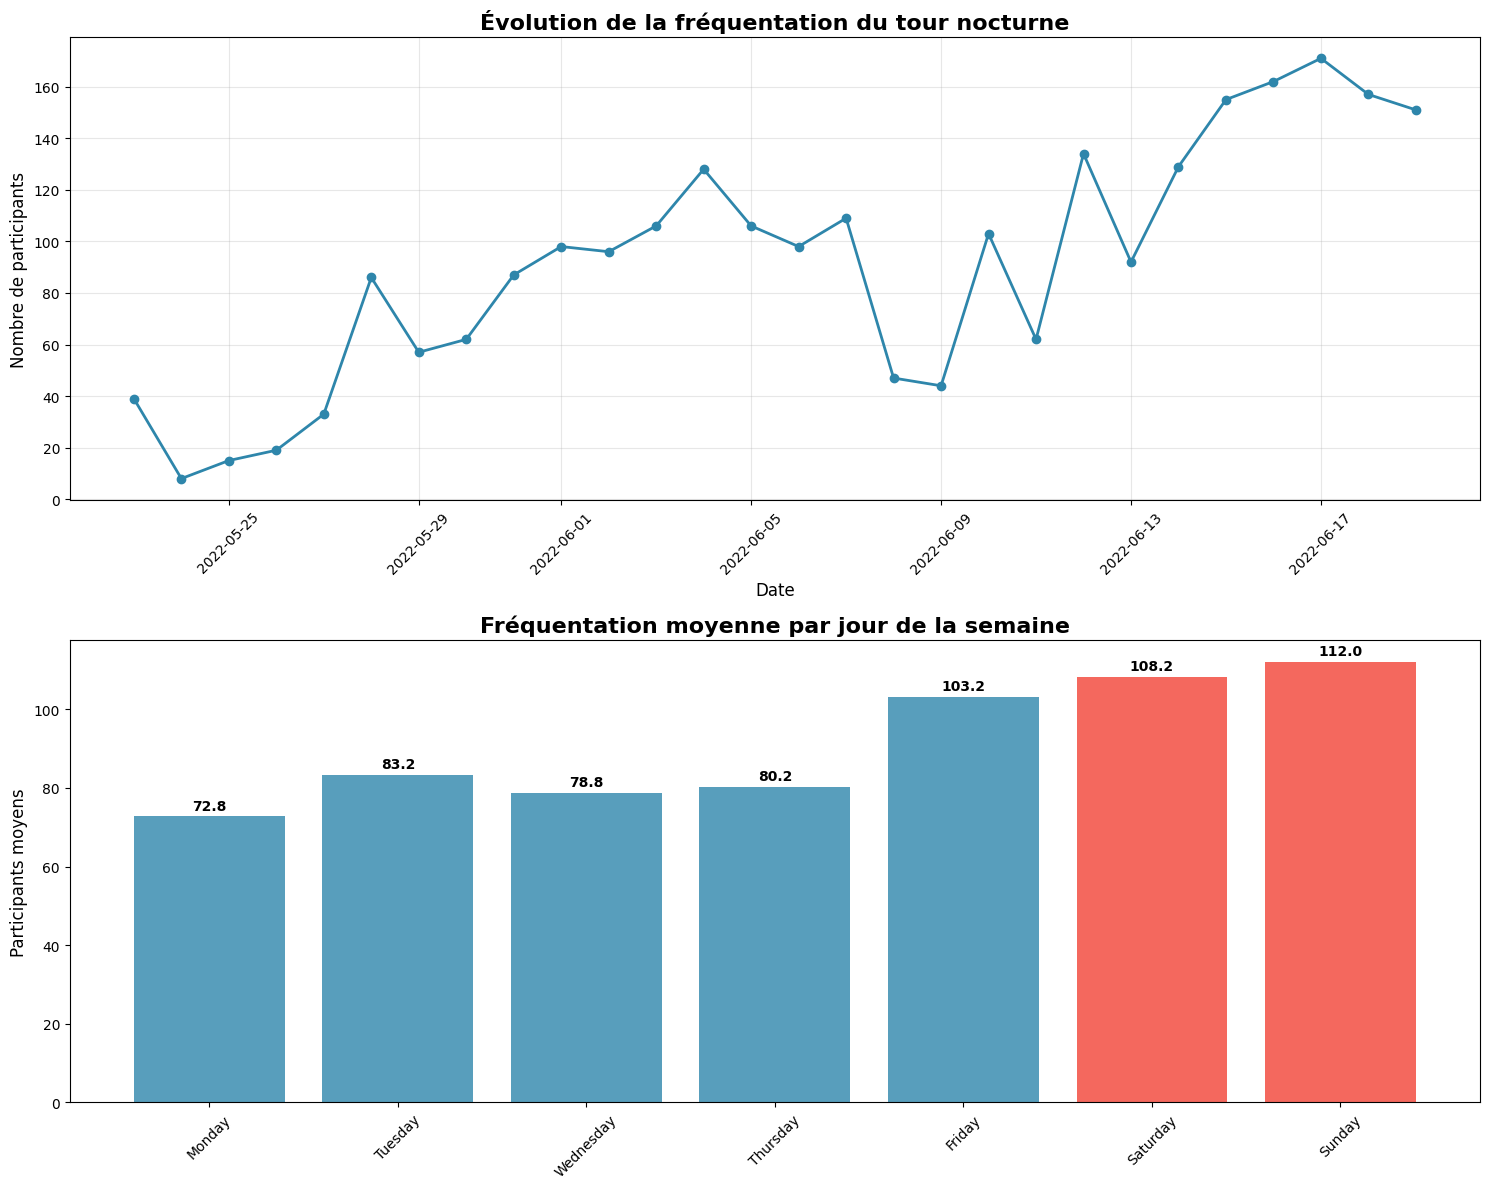


🌤️ Création graphique 2: Impact météo et profils clients...


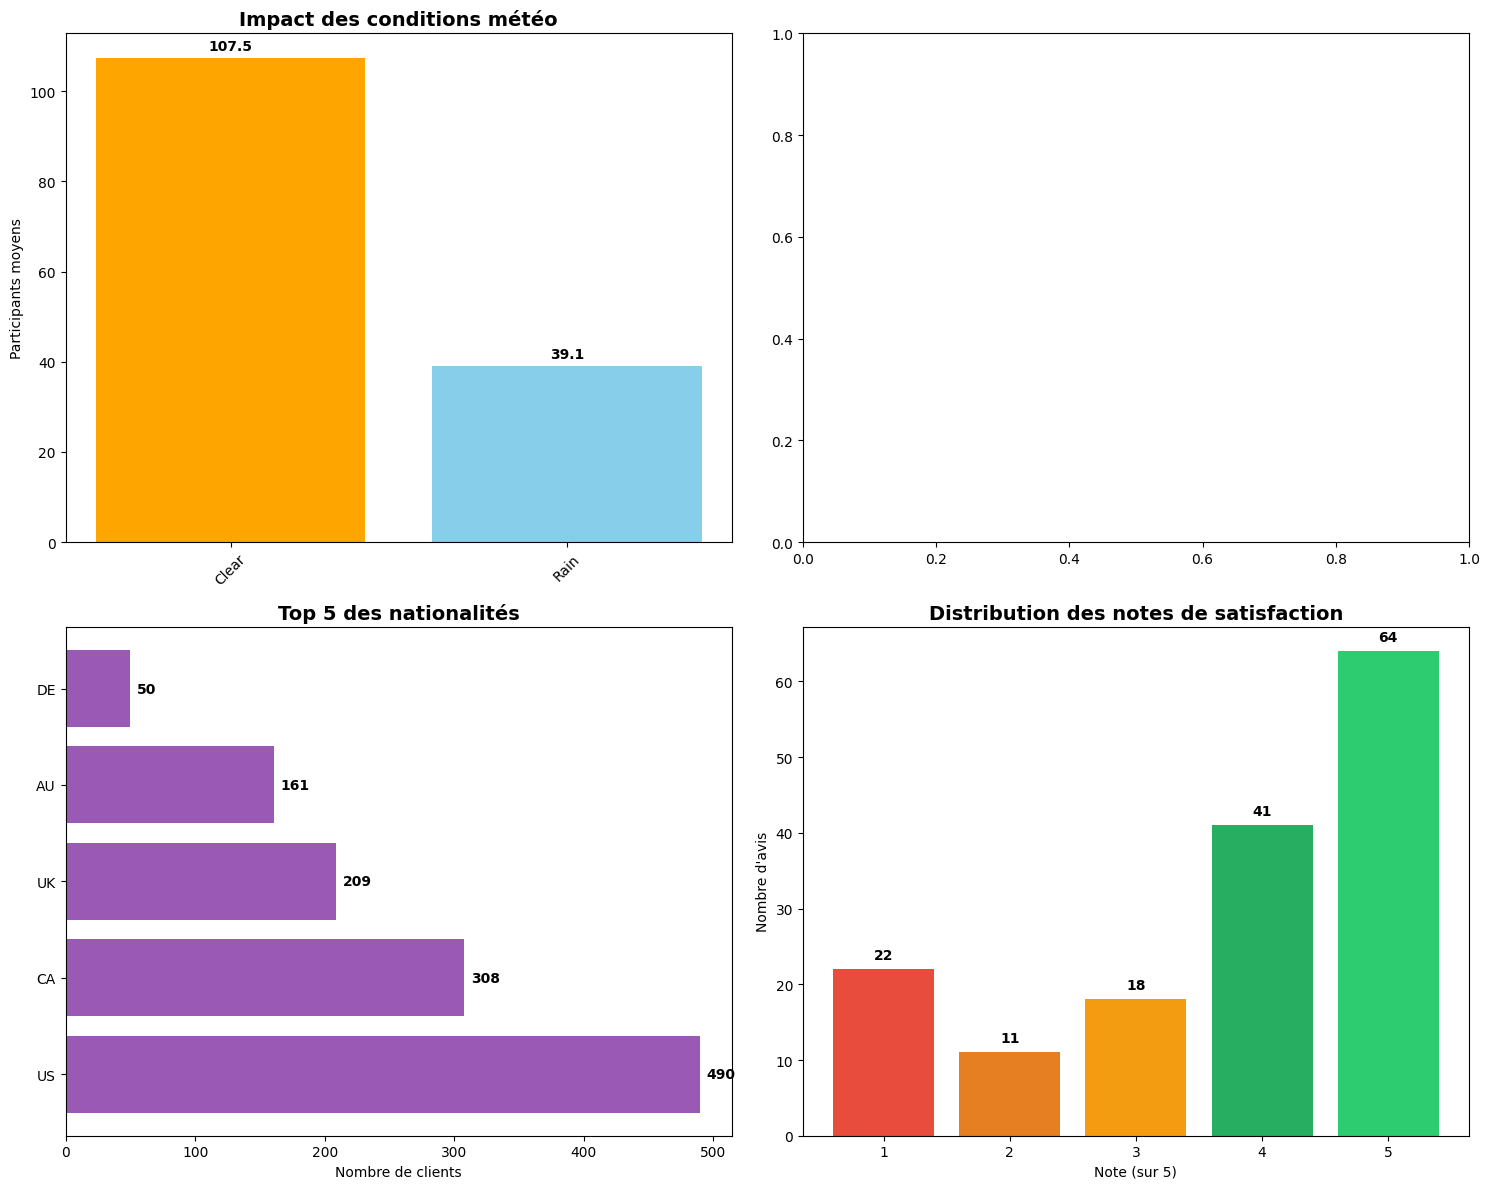


🔄 Création graphique 3: Analyse des flux opérationnels...


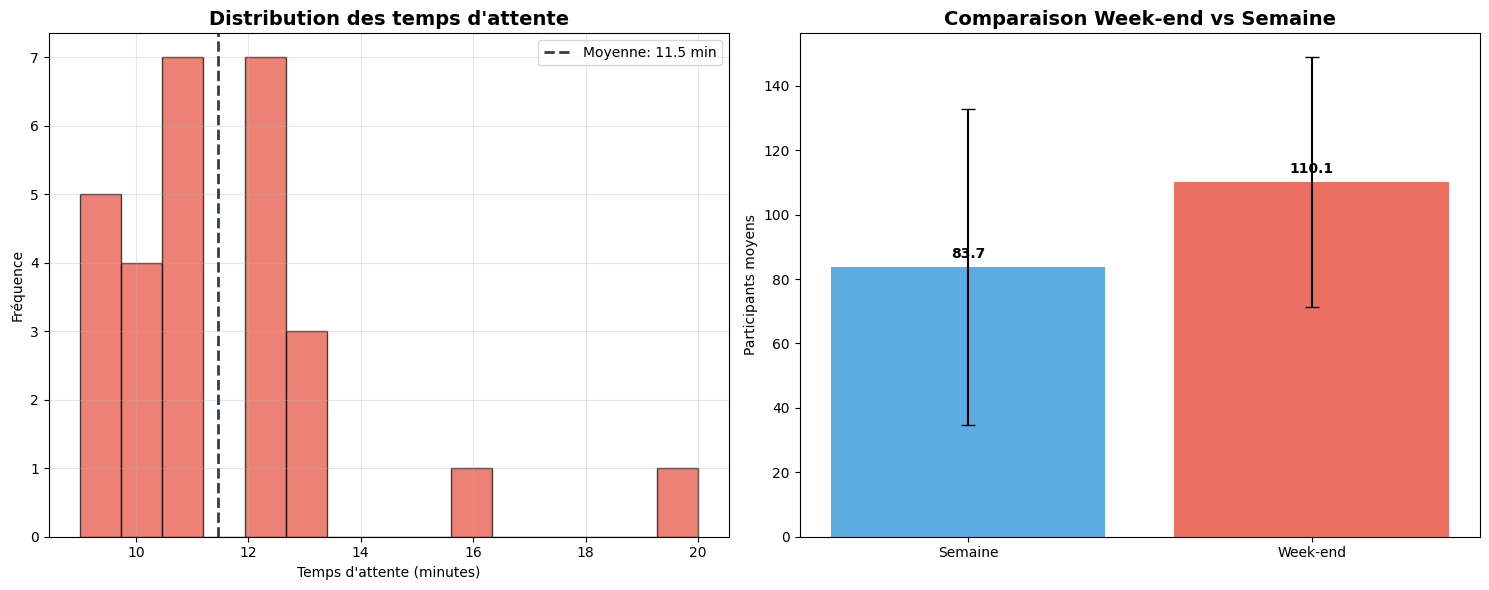


✅ VISUALISATIONS CRÉÉES - Prêt pour les insights business


In [93]:
# =============================================================================
# ÉTAPE 3: VISUALISATIONS ET INSIGHTS
# =============================================================================
print("\n📈 ÉTAPE 3: VISUALISATIONS ET INSIGHTS")
print("-" * 50)

# Configuration pour les graphiques
plt.rcParams['figure.figsize'] = (15, 10)

# 3.1 GRAPHIQUE 1: ÉVOLUTION DE LA FRÉQUENTATION
print("\n📊 Création graphique 1: Évolution de la fréquentation...")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Évolution temporelle
daily_attendance_sorted = daily_attendance.sort_values('date')
ax1.plot(daily_attendance_sorted['date'], daily_attendance_sorted['participants'], 
         marker='o', linewidth=2, markersize=6, color='#2E86AB')
ax1.set_title('Évolution de la fréquentation du tour nocturne', fontsize=16, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Nombre de participants', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Fréquentation par jour de la semaine
freq_by_day_ordered = daily_attendance.groupby('day_of_week')['participants'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
colors = ['#F24236' if day in ['Saturday', 'Sunday'] else '#2E86AB' for day in freq_by_day_ordered.index]
bars = ax2.bar(freq_by_day_ordered.index, freq_by_day_ordered.values, color=colors, alpha=0.8)
ax2.set_title('Fréquentation moyenne par jour de la semaine', fontsize=16, fontweight='bold')
ax2.set_ylabel('Participants moyens', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Ajout des valeurs sur les barres
for bar, value in zip(bars, freq_by_day_ordered.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 3.2 GRAPHIQUE 2: IMPACT MÉTÉO ET PROFILS CLIENTS
print("\n🌤️ Création graphique 2: Impact météo et profils clients...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Impact météo sur fréquentation
# Impact météo sur fréquentation
if len(attendance_weather) > 0:
    weather_avg = attendance_weather.groupby('weather')['participants'].mean().sort_values(ascending=False)
    bars1 = ax1.bar(weather_avg.index, weather_avg.values, 
                    color=['#FFA500', '#87CEEB', '#D3D3D3'][:len(weather_avg)])
    ax1.set_title('Impact des conditions météo', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Participants moyens')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars1, weather_avg.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

# Top nationalités
top_5_nat = customers_clean['nationality'].value_counts().head(5)
bars3 = ax3.barh(top_5_nat.index, top_5_nat.values, color='#9B59B6')
ax3.set_title('Top 5 des nationalités', fontsize=14, fontweight='bold')
ax3.set_xlabel('Nombre de clients')

for i, value in enumerate(top_5_nat.values):
    ax3.text(value + 5, i, str(value), va='center', fontweight='bold')

# Satisfaction client
rating_counts = reviews_clean['rating'].value_counts().sort_index()
colors_rating = ['#E74C3C', '#E67E22', '#F39C12', '#27AE60', '#2ECC71']
bars4 = ax4.bar(rating_counts.index, rating_counts.values, 
                color=[colors_rating[int(i)-1] for i in rating_counts.index])
ax4.set_title('Distribution des notes de satisfaction', fontsize=14, fontweight='bold')
ax4.set_xlabel('Note (sur 5)')
ax4.set_ylabel('Nombre d\'avis')

for bar, value in zip(bars4, rating_counts.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 3.3 GRAPHIQUE 3: ANALYSE DES FLUX OPÉRATIONNELS
print("\n🔄 Création graphique 3: Analyse des flux opérationnels...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Temps d'attente si disponible
if len(wait_times_df) > 0:
    ax1.hist(wait_times_df['wait_time_minutes'], bins=15, color='#E74C3C', alpha=0.7, edgecolor='black')
    ax1.axvline(wait_times_df['wait_time_minutes'].mean(), color='#2C3E50', 
                linestyle='--', linewidth=2, label=f'Moyenne: {wait_times_df["wait_time_minutes"].mean():.1f} min')
    ax1.set_title('Distribution des temps d\'attente', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Temps d\'attente (minutes)')
    ax1.set_ylabel('Fréquence')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Évolution week-end vs semaine
weekend_comparison = daily_attendance.groupby('weekend')['participants'].agg(['mean', 'std'])
categories = ['Semaine', 'Week-end']
means = [weekend_comparison.loc[False, 'mean'], weekend_comparison.loc[True, 'mean']]
stds = [weekend_comparison.loc[False, 'std'], weekend_comparison.loc[True, 'std']]

bars = ax2.bar(categories, means, yerr=stds, capsize=5, 
               color=['#3498DB', '#E74C3C'], alpha=0.8)
ax2.set_title('Comparaison Week-end vs Semaine', fontsize=14, fontweight='bold')
ax2.set_ylabel('Participants moyens')

for bar, mean in zip(bars, means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ VISUALISATIONS CRÉÉES - Prêt pour les insights business")


In [ ]:
# =============================================================================
# ÉTAPE 4: INSIGHTS BUSINESS ET RECOMMANDATIONS
# =============================================================================
print("\n💡 ÉTAPE 4: INSIGHTS BUSINESS ET RECOMMANDATIONS")
print("=" * 60)

# 4.1 CALCULS DES KPIs CLÉS
print("\n📊 CALCUL DES KPIs CLÉS")
print("-" * 30)

# KPI 1: Taux d'occupation moyen
capacity_per_guide = 16  # Capacité officielle par guide
max_daily_capacity = capacity_per_guide * 8  # Estimation 8 groupes max/jour

avg_daily_attendance = daily_attendance['participants'].mean()
occupation_rate = (avg_daily_attendance / max_daily_capacity) * 100

print(f"🎯 Taux d'occupation moyen: {occupation_rate:.1f}%")
print(f"   Participants moyens/jour: {avg_daily_attendance:.1f}")
print(f"   Capacité théorique: {max_daily_capacity} participants/jour")

# KPI 2: Revenus potentiels
price_per_person = 45  # Prix estimé du tour nocturne
total_participants = daily_attendance['participants'].sum()
total_revenue = total_participants * price_per_person
avg_daily_revenue = total_revenue / len(daily_attendance)

print(f"\n💰 Revenus sur la période:")
print(f"   Total participants: {total_participants}")
print(f"   Revenus totaux: {total_revenue:,}€")
print(f"   Revenus moyens/jour: {avg_daily_revenue:.0f}€")

# KPI 3: Performance week-end vs semaine
weekend_performance = daily_attendance.groupby('weekend')['participants'].mean()
weekend_uplift = ((weekend_performance[True] - weekend_performance[False]) / weekend_performance[False]) * 100

print(f"\n📈 Performance Week-end vs Semaine:")
print(f"   Week-end: {weekend_performance[True]:.1f} participants/jour")
print(f"   Semaine: {weekend_performance[False]:.1f} participants/jour")
print(f"   Uplift week-end: +{weekend_uplift:.1f}%")

# 4.2 IDENTIFICATION DES OPPORTUNITÉS
print("\n🎯 IDENTIFICATION DES OPPORTUNITÉS")
print("-" * 40)

# Opportunité 1: Jours sous-performants
low_performance_days = daily_attendance[daily_attendance['participants'] < avg_daily_attendance * 0.7]
print(f"⚠️  Jours sous-performants ({len(low_performance_days)} jours):")
print(f"   Critère: < {avg_daily_attendance * 0.7:.1f} participants")

# Opportunité 2: Impact météo
# Opportunité 2: Impact météo
if len(attendance_weather) > 0:
    weather_performance = attendance_weather.groupby('weather')['participants'].mean()
    best_weather = weather_performance.idxmax()
    worst_weather = weather_performance.idxmin()
    weather_gap = weather_performance[best_weather] - weather_performance[worst_weather]
    
    print(f"\n🌤️  Impact météorologique:")
    print(f"   Meilleure condition: {best_weather} ({weather_performance[best_weather]:.1f} participants)")
    print(f"   Moins bonne: {worst_weather} ({weather_performance[worst_weather]:.1f} participants)")
    print(f"   Écart: {weather_gap:.1f} participants ({weather_gap * price_per_person:.0f}€/jour)")

# Opportunité 3: Satisfaction client
satisfaction_rate = len(reviews_clean[reviews_clean['rating'] >= 4]) / len(reviews_clean) * 100
avg_rating = reviews_clean['rating'].mean()

print(f"\n⭐ Satisfaction client:")
print(f"   Note moyenne: {avg_rating:.2f}/5")
print(f"   Taux de satisfaction (≥4/5): {satisfaction_rate:.1f}%")

if avg_rating < 4.0:
    print(f"   ⚠️  Marge d'amélioration identifiée")

# 4.3 RECOMMANDATIONS STRATÉGIQUES
print("\n🚀 RECOMMANDATIONS STRATÉGIQUES")
print("=" * 40)

print("\n1️⃣  OPTIMISATION DE LA CAPACITÉ")
if occupation_rate < 60:
    print(f"   • Taux d'occupation actuel de {occupation_rate:.1f}% trop faible")
    print(f"   • Potentiel d'augmentation: +{(60-occupation_rate)/100 * max_daily_capacity:.0f} participants/jour")
    print(f"   • Impact revenus: +{((60-occupation_rate)/100 * max_daily_capacity * price_per_person):.0f}€/jour")

print("\n2️⃣  STRATÉGIE MÉTÉO")
if len(attendance_weather) > 0:
    print(f"   • Développer des alternatives pour mauvais temps")
    print(f"   • Potentiel de réduction des pertes: {weather_gap * price_per_person:.0f}€/jour de mauvais temps")

print("\n3️⃣  VALORISATION WEEK-END")
if weekend_uplift > 0:
    print(f"   • Week-end surperforme de {weekend_uplift:.1f}%")
    print(f"   • Envisager une tarification premium week-end")
    print(f"   • Potentiel revenus supplémentaires: +5-10% sur les week-ends")

print("\n4️⃣  AMÉLIORATION EXPÉRIENCE CLIENT")
if avg_rating < 4.5:
    print(f"   • Note actuelle: {avg_rating:.2f}/5 - Objectif: 4.5+/5")
    print(f"   • Focus sur les points de friction identifiés")
    print(f"   • Amélioration satisfaction = +fidélisation et bouche-à-oreille")

# 4.4 PLAN D'ACTION PRIORITAIRE
print("\n📋 PLAN D'ACTION PRIORITAIRE")
print("=" * 35)

print("\n🥇 PRIORITÉ 1 (Impact immédiat):")
print("   □ Ajuster la capacité des jours sous-performants")
print("   □ Mettre en place une stratégie météo")
print("   □ Optimiser les créneaux horaires")

print("\n🥈 PRIORITÉ 2 (Impact moyen terme):")
print("   □ Développer une offre premium week-end")
print("   □ Améliorer l'expérience client (formation guides)")
print("   □ Mettre en place un système de feedback en temps réel")

print("\n🥉 PRIORITÉ 3 (Impact long terme):")
print("   □ Diversifier les profils clients (jeunes 18-25)")
print("   □ Développer des partenariats météo-dépendants")
print("   □ Implémenter un système de yield management")

# 4.5 MÉTRIQUES DE SUIVI
print("\n📈 MÉTRIQUES DE SUIVI RECOMMANDÉES")
print("-" * 40)

print("📊 KPIs opérationnels à suivre:")
print("   • Taux d'occupation journalier (Objectif: >70%)")
print("   • Revenus par participant (Objectif: 45€+)")
print("   • Temps d'attente moyen (Objectif: <20min)")
print("   • Taux d'annulation météo (Objectif: <15%)")

print("\n📊 KPIs satisfaction:")
print("   • Note moyenne satisfaction (Objectif: >4.5/5)")
print("   • Taux de recommandation (Objectif: >90%)")
print("   • Taux de réclamation (Objectif: <5%)")

print("\n✅ ANALYSE TERMINÉE - Présentation prête pour le conseil d'administration")



💡 ÉTAPE 4: INSIGHTS BUSINESS ET RECOMMANDATIONS

📊 CALCUL DES KPIs CLÉS
------------------------------
🎯 Taux d'occupation moyen: 71.3%
   Participants moyens/jour: 91.2
   Capacité théorique: 128 participants/jour

💰 Revenus sur la période:
   Total participants: 2554
   Revenus totaux: 114,930€
   Revenus moyens/jour: 4105€

📈 Performance Week-end vs Semaine:
   Week-end: 110.1 participants/jour
   Semaine: 83.7 participants/jour
   Uplift week-end: +31.6%

🎯 IDENTIFICATION DES OPPORTUNITÉS
----------------------------------------
⚠️  Jours sous-performants (10 jours):
   Critère: < 63.8 participants

🌤️  Impact météorologique:
   Meilleure condition: Clear (107.5 participants)
   Moins bonne: Rain (39.1 participants)
   Écart: 68.3 participants (3075€/jour)

⭐ Satisfaction client:
   Note moyenne: 3.73/5
   Taux de satisfaction (≥4/5): 67.3%
   ⚠️  Marge d'amélioration identifiée

🚀 RECOMMANDATIONS STRATÉGIQUES

1️⃣  OPTIMISATION DE LA CAPACITÉ

2️⃣  STRATÉGIE MÉTÉO
   • Développer